In [37]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

import urllib

In [7]:
# Config & Setup Details
cfg_batch_size  = 20
cfg_max_epochs  = 10
cfg_num_workers = 2

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"
cfg_data_url_test  = "https://s3.amazonaws.com/mtsu.csci.7850.project/test.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "data-loader"


In [8]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [29]:
# Get Training Data
filename, headers = urllib.request.urlretrieve(cfg_data_url_test)
data = np.genfromtxt(filename, delimiter=cfg_data_separator, dtype=str, skip_header=1)

# Convert Dates
dates_np = data[:, 1].astype('datetime64')
data[:, 1] = dates_np  # If using numpy.datetime64

data[:, 2] = data[:, 2].astype(float)

In [33]:
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    
    
train_df = load_data(cfg_data_url_train)
test_df = load_data(cfg_data_url_test)

Shape: (913000, 4)


,date,store,item,sales
611629,2017-10-12,5,34,17
114291,2015-12-16,3,7,51
142579,2013-06-01,9,8,85
320404,2015-05-05,6,18,64
818707,2014-10-22,9,45,75
15151,2014-06-28,9,1,34
882187,2013-08-18,4,49,38
858000,2017-05-26,10,47,24
15223,2014-09-08,9,1,17
886263,2014-10-16,6,49,23


Shape: (45000, 4)


,id,date,store,item
24114,24114,2018-03-26,8,27
44968,44968,2018-02-28,10,50
23514,23514,2018-01-25,2,27
13374,13374,2018-02-24,9,15
21344,21344,2018-01-15,8,24
2876,2876,2018-03-28,2,4
43692,43692,2018-02-12,6,49
8674,8674,2018-02-04,7,10
44847,44847,2018-01-28,9,50
29877,29877,2018-03-29,2,34


Before filter: (913000, 4)
After filter: (1826, 4)


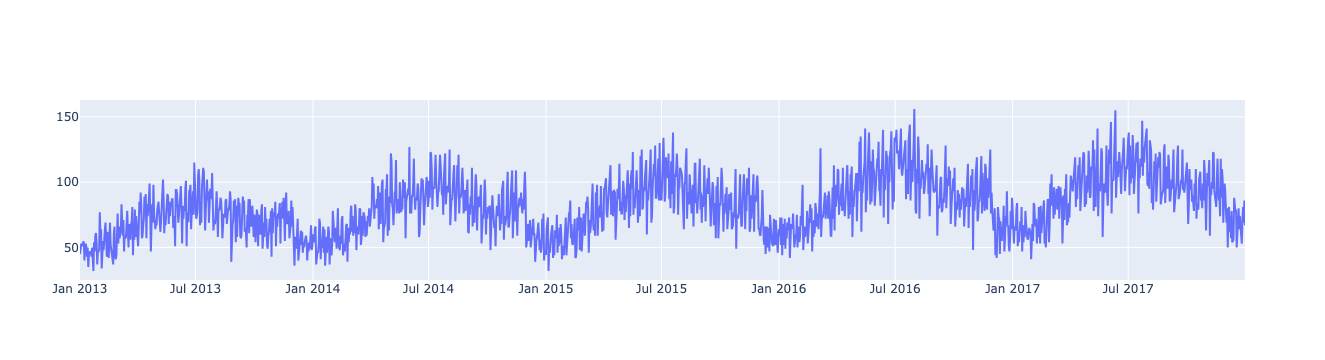

In [41]:
def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 10    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)